In [42]:
# let's download a pretrained version of AlexNet from torchvision
import torch
import torchvision
import matplotlib.pyplot as plt
import cbir
import numpy as np
import os
import pandas as pd
import math
import random

## Functions

In [28]:
def sort_MM(gdata):
    
    evaldb = []
    MMs = []
    
    for g in gdata:
        label = g["mark_label"]
        
        if label not in MMs:
            
            MMs.append(label)
            found = []
            
            for mark in gdata:
                if label == mark["mark_label"]:
                    
                    fname = mark["filename"].split(".")
                    found.append(fname[0] + "_" + str(mark["index"]) + "." + fname[1])
                else:
                    continue
            
            if len(found) > 1:
                MMPP = {
                    "mark_label": label,
                    "PPs": found
                }

                evaldb.append(MMPP)
    
    return evaldb

In [29]:
# Function to calculate the recall
def cal_metric(fname, gdata, ret_ids, retsize):
    
    acquired = 0
    total = 0
    
    # Get the index of the query
    query_index = fname.split("_")[3].split(".")[0]
    query = ""
    
    #print("query_index: " + str(query_index))
    
    # Get the mark label for the query
    for mark in gdata:
        #print(mark["index"])
        if int(query_index) == int(mark["index"]):
            query = mark["mark_label"]
            break
    
    # Find all the marks that have the same label
    for mark in gdata:
        # If labels match
        if query == mark["mark_label"]:
            # Add to total possible matches
            total += 1
            for ret_id in ret_ids:
                # Check if this match was recalled
                #print(ret_id)
                ret_index = int(ret_id.split("_")[3].split(".")[0])
                if ret_index == mark["index"]:
                    acquired += 1
    
    # To account for the query itself
    acquired -= 1
    total -= 1
    
    if total == 0:
        #print("This mark is unique")
        #print(fname)
        return 1
    else:
        recall = acquired/total
        precision = acquired/(retsize)
        
        if precision == 0 and recall == 0:
            #print("No matches")
            #print(fname)
            #print("There are " + str(total) + " possible matches")
            return(0,0)

        metrics = [precision, recall]
    
        return metrics

In [30]:
# Function to calculate the recall
def cal_metric_sanity(fname, gdata, ret_ids, retsize):
    
    acquired = 0
    total = 0
    
    # Get the index of the query
    query_index = fname.split("_")[3].split(".")[0]
    query = ""
    
    #print("query_index: " + str(query_index))
    
    # Get the mark label for the query
    for mark in gdata:
        #print(mark["index"])
        if int(query_index) == int(mark["index"]):
            query = mark["mark_label"]
            break
    
    # Find all the marks that have the same label
    for mark in gdata:
        # If labels match
        if query == mark["mark_label"]:
            # Add to total possible matches
            total += 1
            for ret_id in ret_ids:
                # Check if this match was recalled
                #print(ret_id)
                ret_index = int(ret_id.split("_")[3].split(".")[0])
                if ret_index == mark["index"]:
                    acquired += 1
    
    # To account for the query itself
    #acquired -= 1
    #total -= 1
    
    if total == 0:
        #print("This mark is unique")
        #print(fname)
        return 1
    else:
        recall = acquired/total
        precision = acquired/(retsize+1)
        
        if precision == 0 and recall == 0:
            #print("No matches")
            #print(fname)
            #print("There are " + str(total) + " possible matches")
            return(0,0)

        metrics = [precision, recall]
    
        return metrics

## Get list of mark images

In [40]:
#Location of images
folder_name = 'MMCroppedLogos'
names = []

for dirName, subdirList, fileList in os.walk(folder_name):
    for fname in fileList:
        print('\t%s' % fname)

        names.append(fname)
        
for x in range(0,7):
    names.pop(-1)
    
    
print(len(names))

	113_21_0095_275.jpg
	114_7_0070_576.jpg
	114_7_0029_350.jpg
	113_21_0092_256.jpg
	114_7_0037_407.jpg
	114_7_0075_650.jpg
	114_7_0071_617.jpg
	114_7_0078_738.jpg
	94_20_0035_41.jpg
	103_7_0026_179.jpg
	114_7_0044_546.jpg
	113_21_0087_232.jpg
	114_7_0070_565.jpg
	114_7_0071_642.jpg
	94_20_0105_142.jpg
	94_20_0027_11.jpg
	105_11_0076_759.jpg
	114_7_0037_406.jpg
	114_7_0077_712.jpg
	113_21_0100_331.jpg
	114_7_0071_635.jpg
	114_7_0037_392.jpg
	114_7_0030_356.jpg
	114_7_0036_387.jpg
	94_20_0105_126.jpg
	103_7_0043_196.jpg
	105_11_0076_761.jpg
	113_21_0099_328.jpg
	114_7_0076_680.jpg
	94_20_0080_74.jpg
	114_7_0038_447.jpg
	114_7_0071_613.jpg
	113_21_0057_219.jpg
	113_21_0096_280.jpg
	114_7_0042_475.jpg
	114_7_0070_561.jpg
	114_7_0077_705.jpg
	114_7_0043_509.jpg
	94_20_0036_51.jpg
	94_20_0105_122.jpg
	114_7_0070_580.jpg
	94_20_0036_52.jpg
	114_7_0071_621.jpg
	113_21_0099_313.jpg
	94_20_0028_26.jpg
	114_7_0036_384.jpg
	114_7_0043_528.jpg
	113_21_0089_247.jpg
	114_7_0071_624.jpg
	105_6_0052_210

## Load Gtruth

In [31]:
# Load ground truth
# Extract Groundtruth data

# Load up the markup co-ordinates
# Load the ground truth csv file
via_export = pd.read_csv("gtruthDB.csv")
factor = 1
gdata = []
# Cycle through each instance of a mark
for x in range(via_export.shape[0]):
    
    # Extract the file name and region properties
    data = via_export.iloc[x]
    #index = data.Unnamed
    filename = data.filename
    mark_label = data.mark_label
    mark = {
        "index":x,
        "filename":filename,
        "mark_label":mark_label
    }
    
    gdata.append(mark)
    
for data in gdata:
    print(data)

{'index': 0, 'filename': '94_20_0026.jpg', 'mark_label': 'GIB'}
{'index': 1, 'filename': '94_20_0026.jpg', 'mark_label': 'GFP'}
{'index': 2, 'filename': '94_20_0026.jpg', 'mark_label': 'WC'}
{'index': 3, 'filename': '94_20_0026.jpg', 'mark_label': 'WC'}
{'index': 4, 'filename': '94_20_0027.jpg', 'mark_label': 'P'}
{'index': 5, 'filename': '94_20_0027.jpg', 'mark_label': 'DC'}
{'index': 6, 'filename': '94_20_0027.jpg', 'mark_label': 'IA'}
{'index': 7, 'filename': '94_20_0027.jpg', 'mark_label': 'IV'}
{'index': 8, 'filename': '94_20_0027.jpg', 'mark_label': 'VR'}
{'index': 9, 'filename': '94_20_0027.jpg', 'mark_label': 'VR'}
{'index': 10, 'filename': '94_20_0027.jpg', 'mark_label': 'VR'}
{'index': 11, 'filename': '94_20_0027.jpg', 'mark_label': 'P'}
{'index': 12, 'filename': '94_20_0027.jpg', 'mark_label': 'DC'}
{'index': 13, 'filename': '94_20_0027.jpg', 'mark_label': 'P'}
{'index': 14, 'filename': '94_20_0027.jpg', 'mark_label': 'IC'}
{'index': 15, 'filename': '94_20_0027.jpg', 'mark_l

## Set up DB

In [32]:
# Init database
MMDataSet = cbir.Dataset(folder="MMCroppedLogos")

## Random Base line (Zero skill)


 For 0documents
The average precision: 0.0
The average recall: 0.0
Total number of instances with recall = 0: 106
0.0
0

 For 5documents
The average precision: 0.009389591981333411
The average recall: 0.010188318206265088
Total number of instances with recall = 0: 75
0.010188318206265088
0.0

 For 10documents
The average precision: 0.007972114021255973
The average recall: 0.012368970023692655
Total number of instances with recall = 0: 69
0.012368970023692655
0.010188318206265088

 For 15documents
The average precision: 0.007504106356775241
The average recall: 0.016975931710993715
Total number of instances with recall = 0: 65
0.016975931710993715
0.012368970023692655

 For 20documents
The average precision: 0.007461617572458742
The average recall: 0.021204165927201615
Total number of instances with recall = 0: 60
0.021204165927201615
0.016975931710993715

 For 25documents
The average precision: 0.007753197224625759
The average recall: 0.028870372052871573
Total number of instances with


 For 575documents
The average precision: 0.008629540204888021
The average recall: 0.7397557546377859
Total number of instances with recall = 0: 0
0.7397557546377859
0.6898109135023102

 For 605documents
The average precision: 0.008640927862409829
The average recall: 0.7842171728773415
Total number of instances with recall = 0: 0
0.7842171728773415
0.7397557546377859

 For 635documents
The average precision: 0.008680785440879905
The average recall: 0.8251536599632353
Total number of instances with recall = 0: 0
0.8251536599632353
0.7842171728773415

 For 665documents
The average precision: 0.008565462560494444
The average recall: 0.8523529604275097
Total number of instances with recall = 0: 0
0.8523529604275097
0.8251536599632353

 For 695documents
The average precision: 0.008571483986139
The average recall: 0.8873654944644916
Total number of instances with recall = 0: 0
0.8873654944644916
0.8523529604275097

 For 725documents
The average precision: 0.008628314179770332
The average rec

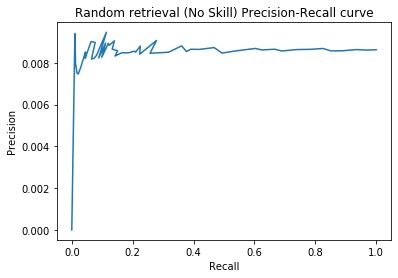

In [43]:
# Calculate average recall and precision for each unique case, EXCLUDE THE QUERY IN EVALUATION

#Lists for precision-recall curve
rando_precision = []
rando_recall = []

# Sort the ground data
evaldb = sort_MM(gdata)
check_new = 0
check_old = 0
r = 0

while check_new != 1:
    
    precision = []
    recall = []
    marks = []
    miss = 0
    # Calculate the metrics
    for x in evaldb:

        marks.append(x["mark_label"])    
        metrics = []

        #Extract files
        files = x["PPs"]
        # Cycle files
        for f in files:
            # Open file
            img = MMDataSet.read_image(f)
            # Get scores and list
            img_id = random.sample(names, r)

            # Calculate the metric
            metric = cal_metric_sanity(f, gdata, img_id, r)
            metrics.append(metric)

        av = np.sum(metrics, axis = 0)/len(files)
        #print(av)
        #print(x["mark_label"])
        precision.append(av[0])
        recall.append(av[1])

        if av[1] == 0:
            miss += 1

    # Calculate the average overall instances
    marks.append("average")
    av_p = np.sum(precision)/len(precision)
    av_r = np.sum(recall)/len(precision)
    
    precision.append(av_p)
    recall.append(av_r)

    print("\n For " + str(r) + "documents")
    print("The average precision: " + str(av_p))
    print("The average recall: " + str(av_r))
    print("Total number of instances with recall = 0: " + str(miss))

    # Append to lists
    rando_precision.append(av_p)
    rando_recall.append(av_r)
    
    check_new = av_r

    print(check_new)
    print(check_old)

    if r == 755:
        r = 775
    elif r > 300:
        r += 30
    elif r > 200:
        r += 20
    elif r > 100:
        r += 10
    else:
        r += 5
    
    check_old = check_new
    
plt.plot(rando_recall, rando_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Random retrieval (No Skill) Precision-Recall curve")
plt.savefig("Figures/rando.svg")
plt.show()

## Ideal Precision-recall curve


 For 1documents
The average precision: 1.0
The average recall: 0.27836079254712776
Total number of instances with recall = 0: 0
1.0
0

 For 6documents
The average precision: 0.6839622641509431
The average recall: 0.8484666420752196
Total number of instances with recall = 0: 0
0.6839622641509431
1.0

 For 11documents
The average precision: 0.4828473413379073
The average recall: 0.9338615002885465
Total number of instances with recall = 0: 0
0.4828473413379073
0.6839622641509431

 For 16documents
The average precision: 0.38089622641509435
The average recall: 0.9762028711087634
Total number of instances with recall = 0: 0
0.38089622641509435
0.4828473413379073

 For 21documents
The average precision: 0.307277628032345
The average recall: 0.9925293386030482
Total number of instances with recall = 0: 0
0.307277628032345
0.38089622641509435

 For 26documents
The average precision: 0.2525399129172714
The average recall: 0.9962586373563425
Total number of instances with recall = 0: 0
0.252539


 For 751documents
The average precision: 0.008906363841921462
The average recall: 1.0
Total number of instances with recall = 0: 0
0.008906363841921462
0.009276947635621383


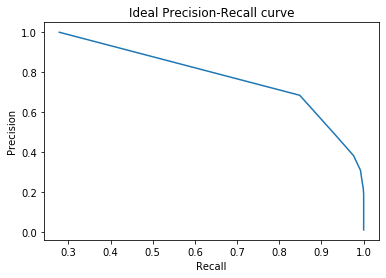

In [44]:
# Calculate average recall and precision for each unique case, EXCLUDE THE QUERY IN EVALUATION

#Lists for precision-recall curve
ideal_precision = []
ideal_recall = []

# Sort the ground data
evaldb = sort_MM(gdata)
check_new = 1
check_old = 0
r = 1

while check_new >= 0.009:
    
    precision = []
    recall = []
    marks = []
    miss = 0
    # Calculate the metrics
    for x in evaldb:

        marks.append(x["mark_label"])    
        metrics = []

        #Extract files
        files = x["PPs"]
        # Cycle files
        for f in files:
            success = []
            failure = []

            for y in range(int(r)):
                if y < len(files):
                    success.append(1)
                else:
                    failure.append(0)

            #Calculate the metrics
            p = len(success)/(len(success)+len(failure))
            re = len(success)/len(files)
            
            metric = [p,re]
            metrics.append(metric)

        av = np.sum(metrics, axis = 0)/len(files)
        #print(av)
        #print(x["mark_label"])
        precision.append(av[0])
        recall.append(av[1])

        if av[1] == 0:
            miss += 1

    # Calculate the average overall instances
    marks.append("average")
    av_p = np.sum(precision)/len(precision)
    av_r = np.sum(recall)/len(precision)
    
    precision.append(av_p)
    recall.append(av_r)

    print("\n For " + str(r) + "documents")
    print("The average precision: " + str(av_p))
    print("The average recall: " + str(av_r))
    print("Total number of instances with recall = 0: " + str(miss))

    # Append to lists
    ideal_precision.append(av_p)
    ideal_recall.append(av_r)
    
    check_new = av_p

    print(check_new)
    print(check_old)

    if r == 756:
        r = 775
    elif r > 300:
        r += 30
    elif r > 200:
        r += 20
    elif r > 100:
        r += 10
    else:
        r += 5
    
    check_old = check_new
    
plt.plot(ideal_recall, ideal_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Ideal Precision-Recall curve")
plt.savefig("Figures/ideal.png")
plt.show()

## Testing conv autoencoder

In [33]:
#Init conv auto DB and index
MMDB_cAutoEnc = cbir.Database(MMDataSet, encoder=cbir.encoders.cOmniAutoEncoder())
MMDB_cAutoEnc.index()


Generating index...
Reshaping 113_21_0099_326.jpg07.140981
Reshaping 113_21_0100_330.jpg07.078492
Reshaping 114_7_0044_538.jpg:03.393869
Reshaping 94_20_0026_2.jpg00:01.289866
Reshaping 94_20_0026_3.jpg00:01.285390
Reshaping 94_20_0080_102.jpg:00.759070
Reshaping 94_20_0080_68.jpg0:00.738181
Reshaping 94_20_0080_72.jpg0:00.706344
Reshaping 94_20_0080_76.jpg0:00.673641
Reshaping 94_20_0080_78.jpg0:00.657971
Reshaping 94_20_0080_81.jpg0:00.634402
Reshaping 94_20_0080_83.jpg0:00.618834
Reshaping 94_20_0080_87.jpg0:00.586155
Reshaping 94_20_0080_89.jpg0:00.570312
Reshaping 94_20_0105_144.jpg:00.146467


0.27836079254712776
0

 For 5documents
The average precision: 1.0
The average recall: 0.27836079254712776
Total number of instances with recall = 0: 0
0.40345661543867317
0.27836079254712776

 For 10documents
The average precision: 0.29488996574999427
The average recall: 0.40345661543867317
Total number of instances with recall = 0: 0
0.4424196323405466
0.40345661543867317

 For 15documents
The average precision: 0.1895655403886963
The average recall: 0.4424196323405466
Total number of instances with recall = 0: 0
0.4786934535350409
0.4424196323405466

 For 20documents
The average precision: 0.14442830153404032
The average recall: 0.4786934535350409
Total number of instances with recall = 0: 0
0.49394689768662065
0.4786934535350409

 For 25documents
The average precision: 0.11667274219871933
The average recall: 0.49394689768662065
Total number of instances with recall = 0: 0
0.5141391960931164
0.49394689768662065

 For 30documents
The average precision: 0.09973581821291518
The average 

0.926920060690818
0.9114514053300125

 For 605documents
The average precision: 0.01037851916625
The average recall: 0.926920060690818
Total number of instances with recall = 0: 0
0.9388227133482859
0.926920060690818

 For 635documents
The average precision: 0.010043225801287118
The average recall: 0.9388227133482859
Total number of instances with recall = 0: 0
0.9471383443753294
0.9388227133482859

 For 665documents
The average precision: 0.009719813930752611
The average recall: 0.9471383443753294
Total number of instances with recall = 0: 0
0.9587784979175547
0.9471383443753294

 For 695documents
The average precision: 0.009453631396122786
The average recall: 0.9587784979175547
Total number of instances with recall = 0: 0
0.9729316522965253
0.9587784979175547

 For 725documents
The average precision: 0.009230540373185414
The average recall: 0.9729316522965253
Total number of instances with recall = 0: 0
0.981306883305899
0.9729316522965253

 For 755documents
The average precision: 0.0

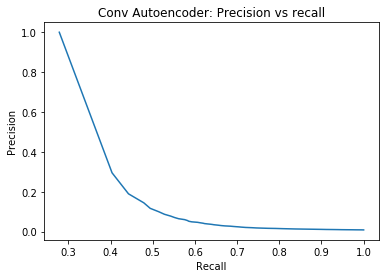

In [34]:
# Calculate average recall and precision for each unique case, EXCLUDE THE QUERY IN EVALUATION

#Lists for precision-recall curve
conv_precision = []
conv_recall = []

# Sort the ground data
evaldb = sort_MM(gdata)
check_new = 0
check_old = 0
r = 0

while check_new != 1:
    
    precision = []
    recall = []
    marks = []
    miss = 0
    # Calculate the metrics
    for x in evaldb:

        marks.append(x["mark_label"])    
        metrics = []

        #Extract files
        files = x["PPs"]
        # Cycle files
        for f in files:
            # Open file
            img = MMDataSet.read_image(f)
            # Get scores and list
            scores = MMDB_cAutoEnc.retrieve(f)
            img_id = list(scores.keys())[0:1+r]

            # Calculate the metric
            metric = cal_metric_sanity(f, gdata, img_id, r)
            metrics.append(metric)

        av = np.sum(metrics, axis = 0)/len(files)
        #print(av)
        #print(x["mark_label"])
        precision.append(av[0])
        recall.append(av[1])

        if av[1] == 0:
            miss += 1

    # Calculate the average overall instances
    marks.append("average")
    av_p = np.sum(precision)/len(precision)
    av_r = np.sum(recall)/len(precision)
    
    precision.append(av_p)
    recall.append(av_r)
    
    check_new = av_r

    print(check_new)
    print(check_old)

    if r > 300:
        r += 30
    elif r > 200:
        r += 20
    elif r > 100:
        r += 10
    else:
        r += 5
    
    check_old = check_new

    print("\n For " + str(r) + "documents")
    print("The average precision: " + str(av_p))
    print("The average recall: " + str(av_r))
    print("Total number of instances with recall = 0: " + str(miss))

    # Append to lists
    conv_precision.append(av_p)
    conv_recall.append(av_r)
    
plt.plot(conv_recall, conv_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Conv Autoencoder: Precision vs recall")
plt.savefig("Figures/cApr.svg")
plt.show()

## Testing denoisingconv autoencoder

In [35]:
# Set up denoising conv DB
MMDB_DcAutoEnc = cbir.Database(MMDataSet, encoder=cbir.encoders.DcOmniAutoEncoder())
MMDB_DcAutoEnc.index()


Generating index...
Reshaping 113_21_0099_326.jpg06.652226
Reshaping 113_21_0100_330.jpg06.562088
Reshaping 114_7_0044_538.jpg:03.150988
Reshaping 94_20_0026_2.jpg00:01.157246
Reshaping 94_20_0026_3.jpg00:01.153300
Reshaping 94_20_0080_102.jpg:00.680401
Reshaping 94_20_0080_68.jpg0:00.660700
Reshaping 94_20_0080_72.jpg0:00.631757
Reshaping 94_20_0080_76.jpg0:00.602653
Reshaping 94_20_0080_78.jpg0:00.588775
Reshaping 94_20_0080_81.jpg0:00.567746
Reshaping 94_20_0080_83.jpg0:00.553808
Reshaping 94_20_0080_87.jpg0:00.524276
Reshaping 94_20_0080_89.jpg0:00.509811
Reshaping 94_20_0105_144.jpg:00.130706


0.27836079254712776
0

 For 5documents
The average precision: 1.0
The average recall: 0.27836079254712776
Total number of instances with recall = 0: 0
0.41109169468040685
0.27836079254712776

 For 10documents
The average precision: 0.3000618762245749
The average recall: 0.41109169468040685
Total number of instances with recall = 0: 0
0.44393568471161676
0.41109169468040685

 For 15documents
The average precision: 0.18846578734376734
The average recall: 0.44393568471161676
Total number of instances with recall = 0: 0
0.4690153599803237
0.44393568471161676

 For 20documents
The average precision: 0.14154060298928015
The average recall: 0.4690153599803237
Total number of instances with recall = 0: 0
0.48355681990333854
0.4690153599803237

 For 25documents
The average precision: 0.11408438795740435
The average recall: 0.48355681990333854
Total number of instances with recall = 0: 0
0.4965847944671356
0.48355681990333854

 For 30documents
The average precision: 0.09663298004472934
The avera

0.9121665047710515
0.8955382209284265

 For 605documents
The average precision: 0.010313420463324749
The average recall: 0.9121665047710515
Total number of instances with recall = 0: 0
0.9298869315628707
0.9121665047710515

 For 635documents
The average precision: 0.010020274325950684
The average recall: 0.9298869315628707
Total number of instances with recall = 0: 0
0.9398637542925299
0.9298869315628707

 For 665documents
The average precision: 0.009719483301041066
The average recall: 0.9398637542925299
Total number of instances with recall = 0: 0
0.9513443373185919
0.9398637542925299

 For 695documents
The average precision: 0.009458839443545579
The average recall: 0.9513443373185919
Total number of instances with recall = 0: 0
0.9686444197748253
0.9513443373185919

 For 725documents
The average precision: 0.009215859721175942
The average recall: 0.9686444197748253
Total number of instances with recall = 0: 0
0.9802212325793729
0.9686444197748253

 For 755documents
The average precis

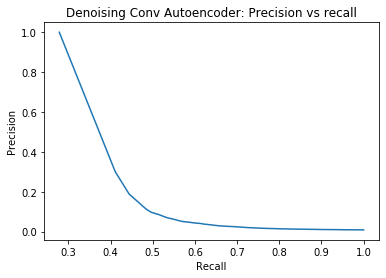

In [36]:
# Calculate average recall and precision for each unique case, EXCLUDE THE QUERY IN EVALUATION

#Lists for precision-recall curve
deco_precision = []
deco_recall = []

# Sort the ground data
evaldb = sort_MM(gdata)
check_new = 0
check_old = 0
r = 0

while check_new != 1:
    
    precision = []
    recall = []
    marks = []
    miss = 0
    # Calculate the metrics
    for x in evaldb:

        marks.append(x["mark_label"])    
        metrics = []

        #Extract files
        files = x["PPs"]
        # Cycle files
        for f in files:
            # Open file
            img = MMDataSet.read_image(f)
            # Get scores and list
            scores =  MMDB_DcAutoEnc.retrieve(f)
            img_id = list(scores.keys())[0:1+r]

            # Calculate the metric
            metric = cal_metric_sanity(f, gdata, img_id, r)
            metrics.append(metric)

        av = np.sum(metrics, axis = 0)/len(files)
        #print(av)
        #print(x["mark_label"])
        precision.append(av[0])
        recall.append(av[1])

        if av[1] == 0:
            miss += 1

    # Calculate the average overall instances
    marks.append("average")
    av_p = np.sum(precision)/len(precision)
    av_r = np.sum(recall)/len(precision)
    
    precision.append(av_p)
    recall.append(av_r)
    
    check_new = av_r

    print(check_new)
    print(check_old)

    if r > 300:
        r += 30
    elif r > 200:
        r += 20
    elif r > 100:
        r += 10
    else:
        r += 5
    
    check_old = check_new

    print("\n For " + str(r) + "documents")
    print("The average precision: " + str(av_p))
    print("The average recall: " + str(av_r))
    print("Total number of instances with recall = 0: " + str(miss))

    # Append to lists
    deco_precision.append(av_p)
    deco_recall.append(av_r)
    
plt.plot(deco_recall, deco_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Denoising Conv Autoencoder: Precision vs recall")
plt.savefig("Figures/deCApr.svg")
plt.show()

## Testing AlexNet encoder

In [37]:
# Set up the AlexNet DB
MMDB_AlexImEmb = cbir.Database(MMDataSet, encoder=cbir.encoders.AlexNet())
MMDB_AlexImEmb.index()


Generating index...
Reshaping 113_21_0099_326.jpg19.760238
Reshaping 113_21_0100_330.jpg19.582347
Reshaping 114_7_0044_538.jpg:13.359230
Reshaping 94_20_0026_2.jpg00:04.927909
Reshaping 94_20_0026_3.jpg00:04.900345
Reshaping 94_20_0080_102.jpg:02.860228
Reshaping 94_20_0080_68.jpg0:02.769148
Reshaping 94_20_0080_72.jpg0:02.644359
Reshaping 94_20_0080_76.jpg0:02.518777
Reshaping 94_20_0080_78.jpg0:02.457559
Reshaping 94_20_0080_81.jpg0:02.366225
Reshaping 94_20_0080_83.jpg0:02.304927
Reshaping 94_20_0080_87.jpg0:02.180189
Reshaping 94_20_0080_89.jpg0:02.118788
Reshaping 94_20_0105_144.jpg:00.545938



 For 0documents
The average precision: 1.0
The average recall: 0.27836079254712776
Total number of instances with recall = 0: 0
0.27836079254712776
0

 For 5documents
The average precision: 0.2837033463178263
The average recall: 0.3823274725882009
Total number of instances with recall = 0: 0
0.3823274725882009
0.27836079254712776

 For 10documents
The average precision: 0.181573328299611
The average recall: 0.4226917082306543
Total number of instances with recall = 0: 0
0.4226917082306543
0.3823274725882009

 For 15documents
The average precision: 0.13800604383190904
The average recall: 0.44688407675182107
Total number of instances with recall = 0: 0
0.44688407675182107
0.4226917082306543

 For 20documents
The average precision: 0.11380168985065564
The average recall: 0.47202736428594216
Total number of instances with recall = 0: 0
0.47202736428594216
0.44688407675182107

 For 25documents
The average precision: 0.09839720538665561
The average recall: 0.49383180520422637
Total number o


 For 575documents
The average precision: 0.011169860567312307
The average recall: 0.965142850787888
Total number of instances with recall = 0: 0
0.965142850787888
0.9613615570927655

 For 605documents
The average precision: 0.010699696889265009
The average recall: 0.9704013907347905
Total number of instances with recall = 0: 0
0.9704013907347905
0.965142850787888

 For 635documents
The average precision: 0.010270270335861689
The average recall: 0.9768645573033318
Total number of instances with recall = 0: 0
0.9768645573033318
0.9704013907347905

 For 665documents
The average precision: 0.00985569104645902
The average recall: 0.9815477785804575
Total number of instances with recall = 0: 0
0.9815477785804575
0.9768645573033318

 For 695documents
The average precision: 0.009491224222380776
The average recall: 0.9895988405565543
Total number of instances with recall = 0: 0
0.9895988405565543
0.9815477785804575

 For 725documents
The average precision: 0.009148731880856256
The average reca

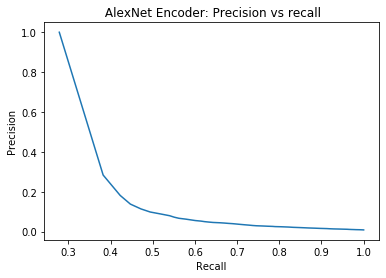

In [38]:
# Calculate average recall and precision for each unique case, EXCLUDE THE QUERY IN EVALUATION
# Save into a CSV

alex_precision = []
alex_recall = []

# Sort the ground data
evaldb = sort_MM(gdata)
check_new = 0
check_old = 0
r = 0

while check_new != 1:
    
    precision = []
    recall = []
    marks = []
    miss = 0
    # Calculate the metrics
    for x in evaldb:

        marks.append(x["mark_label"])    
        metrics = []

        #Extract files
        files = x["PPs"]
        # Cycle files
        for f in files:
            # Open file
            img = MMDataSet.read_image(f)
            # Get scores and list
            scores = MMDB_AlexImEmb.retrieve(f)
            img_id = list(scores.keys())[0:1+r]

            # Calculate the metric
            metric = cal_metric_sanity(f, gdata, img_id, r)
            metrics.append(metric)

        av = np.sum(metrics, axis = 0)/len(files)
        
        #print(av)
        #print(x["mark_label"])
        precision.append(av[0])
        recall.append(av[1])

        if av[1] == 0:
            miss += 1

    # Calculate the average overall instances
    marks.append("average")
    av_p = np.sum(precision)/len(precision)
    av_r = np.sum(recall)/len(precision)
    
    precision.append(av_p)
    recall.append(av_r)

    print("\n For " + str(r) + "documents")
    print("The average precision: " + str(av_p))
    print("The average recall: " + str(av_r))
    print("Total number of instances with recall = 0: " + str(miss))

    # Append to lists
    alex_precision.append(av_p)
    alex_recall.append(av_r)
    
    check_new = av_r

    print(check_new)
    print(check_old)

    if r > 300:
        r += 30
    elif r > 200:
        r += 20
    elif r > 100:
        r += 10
    else:
        r += 5
    
    check_old = check_new
    
plt.plot(alex_recall, alex_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(" AlexNet Encoder: Precision vs recall")
plt.savefig("Figures/alexpr.svg")
plt.show()

## Comparing results

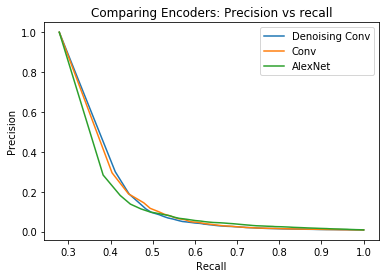

In [46]:
plt.plot(deco_recall, deco_precision, label="Denoising Conv")
plt.plot(conv_recall, conv_precision, label="Conv")
plt.plot(alex_recall, alex_precision, label="AlexNet")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Comparing Encoders: Precision vs recall")
plt.savefig("Figures/compare_pr.svg")
plt.show()

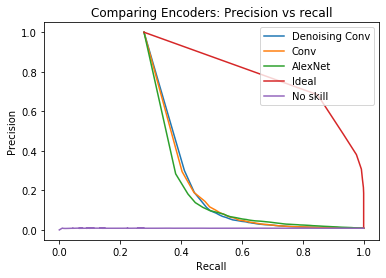

In [47]:
plt.plot(deco_recall, deco_precision, label="Denoising Conv")
plt.plot(conv_recall, conv_precision, label="Conv")
plt.plot(alex_recall, alex_precision, label="AlexNet")
plt.plot(ideal_recall, ideal_precision, label="Ideal")
plt.plot(rando_recall, rando_precision, label="No skill")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Comparing Encoders: Precision vs recall")
plt.savefig("Figures/compare_irpr.svg")
plt.show()
